### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime as dt
import scipy.stats as stats
import scipy.sparse
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score, confusion_matrix, make_scorer

### Import data

In [2]:
data_path = r'data/clean_df.csv.gz'
df = pd.read_csv(data_path)
df.head()

,Unnamed: 0,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,...,DISTANCE FROM MADISON SQUARE GARDEN,DISTANCE FROM PORT AUTHORITY,DISTANCE FROM GRAND ARMY PLAZA,DISTANCE FROM TRIBECA,DISTANCE FROM BATTERY PARK,DISTANCE FROM SOHO,DISTANCE FROM CONEY ISLAND,DAYS FROM NEW YEARS,DAYS FROM CHRISTMAS,DAYS FROM JULY 4
0,0,2017-06-26 00:00:00,2020-09-22 22:00:00,MANHATTAN,10002.0,40.718270,-73.99072,POINT (-73.99072 40.71827),ALLEN STREET,BROOME STREET,...,0.032134,0.038880,0.051023,0.017988,0.029482,0.013270,0.144167,176 days,-182 days,-8 days
1,1,2017-07-14 00:00:00,2020-09-22 13:17:00,NaN,10028.0,40.783180,-73.94362,POINT (-73.94362 40.78318),FDR DRIVE,NaN,...,0.059596,0.054004,0.113396,0.093249,0.107943,0.084330,0.209438,194 days,-164 days,10 days
2,2,2017-07-04 00:00:00,2020-09-22 14:00:00,BRONX,10462.0,40.833557,-73.85774,POINT (-73.85774 40.833557),WESTCHESTER AVENUE,PUGSLEY AVENUE,...,0.159107,0.153556,0.195316,0.191071,0.205098,0.182365,0.281697,184 days,-174 days,0 days
3,3,2017-07-17 00:00:00,2020-09-22 21:03:00,MANHATTAN,10032.0,40.833843,-73.94851,POINT (-73.94851 40.833843),RIVERSIDE DRIVE,WEST 155 STREET,...,0.094805,0.087647,0.162559,0.132012,0.147135,0.123243,0.259294,197 days,-161 days,13 days
4,4,2017-06-26 00:00:00,2020-09-22 15:35:00,BROOKLYN,11203.0,40.654434,-73.92139,POINT (-73.92139 40.654434),REMSEN AVENUE,LINDEN BOULEVARD,...,0.119852,0.124044,0.050176,0.106925,0.106393,0.106784,0.093070,176 days,-182 days,-8 days


In [4]:
df['CRASH DATE'] = pd.to_datetime(df['CRASH DATE'])
df['CRASH TIME'] = pd.to_datetime(df['CRASH TIME'])

### Create target

In [5]:
df['CASUALTIES?'] = 0
mask = df['TOTAL PEDESTRIAN CASUALTIES'] != 0
df.loc[mask, 'CASUALTIES?'] = 1
df.loc[df['TOTAL PEDESTRIAN CASUALTIES'] != 1, ['TOTAL PEDESTRIAN CASUALTIES','CASUALTIES?']].sample(5)

,TOTAL PEDESTRIAN CASUALTIES,CASUALTIES?
1373903,0,0
1236589,0,0
1464873,0,0
634732,0,0
254683,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1486656 entries, 0 to 1486655
Data columns (total 56 columns):
 #   Column                               Non-Null Count    Dtype         
---  ------                               --------------    -----         
 0   Unnamed: 0                           1486656 non-null  int64         
 1   CRASH DATE                           1486656 non-null  datetime64[ns]
 2   CRASH TIME                           1486656 non-null  datetime64[ns]
 3   BOROUGH                              1143388 non-null  object        
 4   ZIP CODE                             1486656 non-null  float64       
 5   LATITUDE                             1486656 non-null  float64       
 6   LONGITUDE                            1486656 non-null  float64       
 7   LOCATION                             1486656 non-null  object        
 8   ON STREET NAME                       1203377 non-null  object        
 9   CROSS STREET NAME                    980930 non-null   ob

## Feature development

### Hyperparameter settings
See _hyperparameter tuning_ notebook for evaluation and selection of hyperparameters.

In [8]:
# Random Forest hyperparameters
rf_params = {
    'class_weight':'balanced',
    'max_depth':15,
    'n_estimators':10,
    'max_features':None,
    'n_jobs':-1,
    'random_state':42
}

# Logistic Regression hyperparameters
log_params = {
    'class_weight':'balanced',
    'max_iter':10_000
}

# KMeans hyperparameters
kmeans_params = {
    'n_clusters':52,
    'random_state':42
}

### Model 1: Add clusters

In [9]:
clusters=52
kmeans = KMeans(**kmeans_params)
kmeans.fit(df[['LATITUDE','LONGITUDE']].values)

KMeans(n_clusters=52, random_state=42)

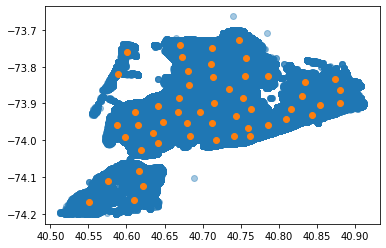

In [10]:
_ = plt.scatter(df['LATITUDE'], df['LONGITUDE'], alpha=0.4)
_ = plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1])

In [11]:
df['CLUSTERS'] = kmeans.labels_

In [12]:
df[['CLUSTERS']].head()

,CLUSTERS
0,20
1,1
2,18
3,15
4,7


In [13]:
borough_dummies = pd.get_dummies(df['BOROUGH'], sparse=True)
cluster_dummies = pd.get_dummies(df['CLUSTERS'], prefix='CLUSTER', sparse=True)

In [14]:
pre_X = cluster_dummies.join(borough_dummies)
X = scipy.sparse.csr_matrix(pre_X)
y = df['CASUALTIES?']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [15]:
log_reg = LogisticRegression(**log_params)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
log_f1 = f1_score(y_test, y_pred)

rf_clf = RandomForestClassifier(**rf_params)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
rf_f1 = f1_score(y_test, y_pred)

print(f'Logistic Regression F1: {log_f1}\nRandom Forest F1: {rf_f1}')

Logistic Regression F1: 0.16672666256372146
Random Forest F1: 0.16807866170546448


### Model 2: Add year/month/season

In [16]:
df['YEAR'] = df['CRASH DATE'].dt.year
df['MONTH'] = df['CRASH DATE'].dt.month

year_dummies = pd.get_dummies(df['YEAR'], sparse=True, prefix='YEAR')
month_dummies = pd.get_dummies(df['MONTH'], sparse=True)
season_dummies = pd.get_dummies(df['SEASON'], sparse=True)

In [17]:
pre_X = pre_X.join(year_dummies).join(season_dummies).join(month_dummies)
X = scipy.sparse.csr_matrix(pre_X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [18]:
log_reg = LogisticRegression(**log_params)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
log_f1 = f1_score(y_test, y_pred)

rf_clf = RandomForestClassifier(**rf_params)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
rf_f1 = f1_score(y_test, y_pred)

print(f'Logistic Regression F1: {log_f1}\nRandom Forest F1: {rf_f1}')

Logistic Regression F1: 0.16753414228671754
Random Forest F1: 0.16837482891220754


### Model 3: Add hour/daytime/rush hour

In [19]:
df['HOUR'] = df['CRASH TIME'].dt.hour
hour_dummies = pd.get_dummies(df['HOUR'], sparse=True, prefix='HOUR')

pre_X = pre_X.join(df[['DURING DAYTIME','RUSH HOUR']]).join(hour_dummies)
X = scipy.sparse.csr_matrix(pre_X)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [21]:
log_reg = LogisticRegression(**log_params)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
log_f1 = f1_score(y_test, y_pred)

rf_clf = RandomForestClassifier(**rf_params)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
rf_f1 = f1_score(y_test, y_pred)

print(f'Logistic Regression F1: {log_f1}\nRandom Forest F1: {rf_f1}')

Logistic Regression F1: 0.17623769842766107
Random Forest F1: 0.17561331775700934


### Model 4: Add weekday

In [22]:
weekday_dummies = pd.get_dummies(df['WEEKDAY'], sparse=True)

pre_X = pre_X.join(weekday_dummies)
X = scipy.sparse.csr_matrix(pre_X)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [24]:
log_reg = LogisticRegression(**log_params)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
log_f1 = f1_score(y_test, y_pred)

rf_clf = RandomForestClassifier(**rf_params)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
rf_f1 = f1_score(y_test, y_pred)

print(f'Logistic Regression F1: {log_f1}\nRandom Forest F1: {rf_f1}')

Logistic Regression F1: 0.176272040302267
Random Forest F1: 0.1751786350884263


### Model 5: Add street names

In [25]:
df.isnull().sum()[df.isnull().sum() != 0].sort_values(ascending=False)

VEHICLE TYPE CODE 5              1481394
CONTRIBUTING FACTOR VEHICLE 5    1481254
VEHICLE TYPE CODE 4              1466545
CONTRIBUTING FACTOR VEHICLE 4    1465994
VEHICLE TYPE CODE 3              1392181
CONTRIBUTING FACTOR VEHICLE 3    1389732
OFF STREET NAME                  1265082
CROSS STREET NAME                 505726
BOROUGH                           343268
ON STREET NAME                    283279
VEHICLE TYPE CODE 2               241964
CONTRIBUTING FACTOR VEHICLE 2     208655
VEHICLE TYPE CODE 1                 7576
CONTRIBUTING FACTOR VEHICLE 1       4112
NUMBER OF PERSONS KILLED              28
NUMBER OF PERSONS INJURED             15
dtype: int64

In [26]:
df['STREET NAME IS NULL'] = df['ON STREET NAME'].isnull().astype('int')
df[['ON STREET NAME', 'STREET NAME IS NULL']].sample(5)

,ON STREET NAME,STREET NAME IS NULL
722881,NaN,1
329893,31 AVENUE,0
586259,SPRINGFIELD BOULEVARD,0
930644,GREENE AVENUE,0
229528,KENMARE STREET,0


In [27]:
df['ON STREET NAME'] = df['ON STREET NAME'].fillna('')
df['ON STREET NAME'].isnull().sum()

0

In [28]:
tfidf = TfidfVectorizer(min_df=50, max_df=.5)
tfidf_df = pd.DataFrame.sparse.from_spmatrix(tfidf.fit_transform(df['ON STREET NAME']))
tfidf_pre = tfidf_df.add_prefix('ON')
pre_X = pre_X.join(tfidf_pre).join(df['STREET NAME IS NULL'])

In [29]:
X = scipy.sparse.csr_matrix(pre_X)
X.shape

(1486656, 1606)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape

(1040659, 1606)

In [31]:
log_reg = LogisticRegression(**log_params)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
log_f1 = f1_score(y_test, y_pred)

rf_clf = RandomForestClassifier(**rf_params)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
rf_f1 = f1_score(y_test, y_pred)

print(f'Logistic Regression F1: {log_f1}\nRandom Forest F1: {rf_f1}')

Logistic Regression F1: 0.19233957311597707
Random Forest F1: 0.17741665270564583


### Model 6: Add off street names

In [32]:
df['OFF STREET NAME'].isnull().sum()

1265082

In [33]:
df['OFF STREET NAME IS NULL'] = df['OFF STREET NAME'].isnull().astype('int')
df[['OFF STREET NAME', 'OFF STREET NAME IS NULL']].sample(5)

,OFF STREET NAME,OFF STREET NAME IS NULL
1019,1767 FULTON AVENUE,0
425680,732 LONGFELLOW AVENUE,0
313658,NaN,1
65158,312 WEST 25 STREET,0
1401755,NaN,1


In [34]:
df['OFF STREET NAME'] = df['OFF STREET NAME'].fillna('')
df['OFF STREET NAME'].isnull().sum()

0

In [35]:
tfidf = TfidfVectorizer(min_df=50, max_df=.5)
tfidfjs_df = pd.DataFrame.sparse.from_spmatrix(tfidf.fit_transform(df['OFF STREET NAME']))
tfidf_pre = tfidf_df.add_prefix('OFF')
pre_X = pre_X.join(tfidf_pre).join(df['OFF STREET NAME IS NULL'])

In [44]:
X = scipy.sparse.csr_matrix(pre_X)
X.shape

ValueError: unrecognized csr_matrix constructor usage

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape

In [ ]:
log_reg = LogisticRegression(**log_params)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
log_f1 = f1_score(y_test, y_pred)

rf_clf = RandomForestClassifier(**rf_params)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
rf_f1 = f1_score(y_test, y_pred)

print(f'Logistic Regression F1: {log_f1}\nRandom Forest F1: {rf_f1}')

### Model 7: Add contributing factors

In [ ]:
df['CONTRIBUTING FACTOR VEHICLE 1'].unique()

In [ ]:
len(df[df['CONTRIBUTING FACTOR VEHICLE 1'] == 'Unspecified'])

In [ ]:
df['CONTRIBUTING FACTOR VEHICLE 1'].isnull().sum()

In [ ]:
df['CONTRIBUTING FACTOR VEHICLE 1'] = df['CONTRIBUTING FACTOR VEHICLE 1'].fillna('Unspecified')
df['CONTRIBUTING FACTOR VEHICLE 1'].isnull().sum()

In [ ]:
factor_dummies = pd.get_dummies(df['CONTRIBUTING FACTOR VEHICLE 1'], sparse=True)

pre_X = pre_X.join(factor_dummies)
X = scipy.sparse.csr_matrix(pre_X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

log_reg = LogisticRegression(log_params)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
log_f1 = f1_score(y_test, y_pred)

rf_clf = RandomForestClassifier(**rf_params)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
rf_f1 = f1_score(y_test, y_pred)

print(f'Logistic Regression F1: {log_f1}\nRandom Forest F1: {rf_f1}')

### Model 8: Add vehicle type code

In [ ]:
vehicle_types = df['VEHICLE TYPE CODE 1'].str.lower().value_counts().sort_values(ascending=False)
vehicle_types[vehicle_types >= 100]

In [ ]:
df['VEHICLE TYPE CODE 1'].isnull().sum()

In [ ]:
df['VEHICLE TYPE CODE 1'] = df['VEHICLE TYPE CODE 1'].fillna('unknown')
df['VEHICLE TYPE CODE 1'].isnull().sum()

In [ ]:
df.loc[df['VEHICLE TYPE CODE 1'].str.lower().str.contains('sedan'), 'VEHICLE TYPE CODE 1'].value_counts()

In [ ]:
df.loc[df['VEHICLE TYPE CODE 1'].str.lower().str.contains('sedan'), 'VEHICLE TYPE CODE 1'] = 'sedan'
df.loc[df['VEHICLE TYPE CODE 1'].str.lower().str.contains('sedan'), 'VEHICLE TYPE CODE 1'].value_counts()

In [ ]:
df.loc[df['VEHICLE TYPE CODE 1'].str.lower().str.contains('sport utility'), 'VEHICLE TYPE CODE 1'].value_counts()

In [ ]:
df.loc[df['VEHICLE TYPE CODE 1'].str.lower().str.contains('sport utility'), 'VEHICLE TYPE CODE 1'] = 'suv'
df.loc[df['VEHICLE TYPE CODE 1'].str.lower().str.contains('sport utility'), 'VEHICLE TYPE CODE 1'].value_counts()

## Other stuff

In [ ]:
confusion_matrix(y_test, y_pred)

In [ ]:
tn, fp, fn, tp  = confusion_matrix(y_test, y_pred).ravel()
print(f'FP: {fp}\nFN: {fn}')

In [ ]:
def fp_rate(y_test, y_pred):
    tn, fp, fn, tp  = confusion_matrix(y_test, y_pred).ravel()
    return fp / (fp + tn)
    
def fn_rate(y_test, y_pred):
    tn, fp, fn, tp  = confusion_matrix(y_test, y_pred).ravel()
    return fn / (tp + fn)

In [ ]:
fp_rate(y_test, y_pred)

In [ ]:
fn_rate(y_test, y_pred)

How many false positives/false negatives for the year?

False positive/false negative rate
How many locations/people will be misidentified? What is the false positive rate?
How many will you fail to identify?

In [ ]:
f1_list = []
for i in range(2,101):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df[['LATITUDE','LONGITUDE']].values)
    df_clusters = pd.Series(kmeans.labels_)
    cluster_dummies = pd.get_dummies(df_clusters)
    X = scipy.sparse.csr_matrix(cluster_dummies)
    y = df['CASUALTIES?']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    log_reg = LogisticRegression(class_weight='balanced', max_iter=10_000)
    log_reg.fit(X_train, y_train)
    y_pred = log_reg.predict(X_test)
    log_f1 = f1_score(y_test, y_pred)
    print(f'# Clusters: {i}\n    F1 score: {log_f1}')
    f1_list.append(log_f1)

In [ ]:
max(f1_list)

In [ ]:
_ = plt.figure(figsize=(10,10))
_ = plt.plot(range(2,101), f1_list, 'k-')
_ = plt.grid()
_ = plt.xlabel('# Clusters', fontsize=14)
_ = plt.ylabel('F1 Score', fontsize=14)
_ = plt.title('F1 Cluster Analysis\n', fontsize=22)
plt.savefig('F1 Cluster Analysis')